# MSA 2024 Phase 2 - Part 2{-}
In this part, I will train a model on the pre-processed data to predict sales numbers for a specific period based on input features. The goal is to predict the sales of the give features. 
These features include: 


## 1. Import libraries and pre-define functions{-}

In [128]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

def smape(y_true, y_pred):
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Calculate the numerator (absolute difference)
    numerator = np.abs(y_true - y_pred)
    # Calculate the denominator (average of absolute actual and predicted values)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Calculate SMAPE
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value


## 2. Load and split preprocessed data{-}
Since I am going to build a time series regression model, I will use the data before 2017/1/1 as training set, and after 2017/1/1 as testing set.

In [178]:
# Load dataset
df = pd.read_csv('./dataset/store_sales_selected.csv', encoding='latin-1')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Year']-2014
df = df.set_index('Order Date')

# Creating lag features
df['sales_lag_7'] = df['Sales'].shift(7)
df['sales_lag_30'] = df['Sales'].shift(30)
df['sales_lag_90'] = df['Sales'].shift(90)
df['sales_lag_180'] = df['Sales'].shift(180)
df['sales_lag_365'] = df['Sales'].shift(365)
df = df.dropna()


In [226]:
df.columns

Index(['Ship Mode', 'Segment', 'City', 'Sub-Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Day of Week', 'Year', 'Month', 'Quarter', 'Days',
       'sales_lag_7', 'sales_lag_30', 'sales_lag_90', 'sales_lag_180',
       'sales_lag_365'],
      dtype='object')

In [179]:
df.tail(10)

,Ship Mode,Segment,City,Sub-Category,Sales,Quantity,Discount,Profit,Day of Week,Year,Month,Quarter,Days,sales_lag_7,sales_lag_30,sales_lag_90,sales_lag_180,sales_lag_365
Order Date,,,,,,,,,,,,,,,,,,
2017-12-28,3,1,316,2,7.4000,2,0.00,3.0340,3,3,12,4,1451,41.9600,18.960,629.640,166.500,31.984
2017-12-28,3,0,294,0,78.8528,2,0.32,-11.5960,3,3,12,4,1451,304.4500,119.833,897.150,128.124,423.648
2017-12-28,3,1,261,2,7.9680,3,0.60,-2.3904,3,3,12,4,1451,21.0000,1141.938,7.712,101.400,418.296
2017-12-29,2,0,185,1,258.7500,3,0.00,77.6250,4,3,12,4,1452,191.9840,99.950,701.960,127.372,74.592
2017-12-29,2,0,185,1,300.9800,1,0.00,87.2842,4,3,12,4,1452,2.9600,13.360,508.704,449.568,16.784
2017-12-29,2,0,185,1,1207.8400,8,0.00,314.0384,4,3,12,4,1452,340.7040,102.018,906.680,2036.860,462.564
2017-12-29,3,0,184,1,393.5680,4,0.20,-44.2764,4,3,12,4,1452,113.3720,15.920,242.352,8.730,9.940
2017-12-29,3,1,5,2,101.1200,8,0.00,37.4144,4,3,12,4,1452,7.4000,182.550,8.752,28.272,40.480
2017-12-29,3,0,95,2,68.4600,2,0.00,20.5380,4,3,12,4,1452,78.8528,220.980,1159.056,30.560,88.020


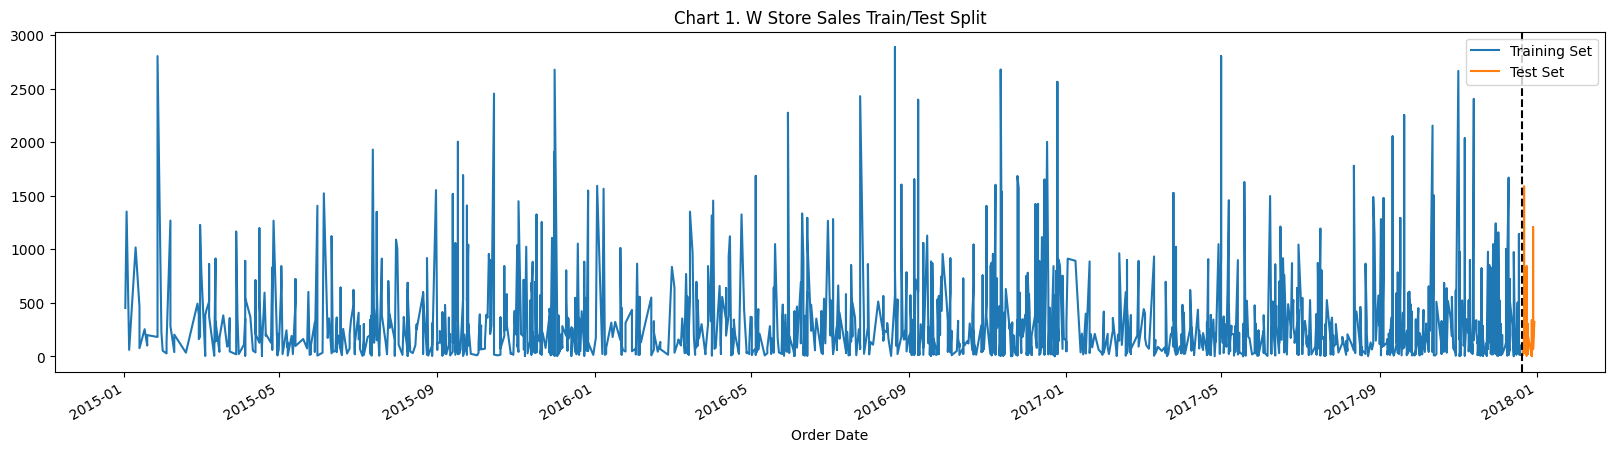

In [193]:
train = df.loc[(df.index < '2017-12-20') & (df.index >= '2015-01-01')]
test = df.loc[df.index >= '2017-12-20']

fig, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, y='Sales', label='Training Set', title='Chart 1. W Store Sales Train/Test Split')
test.plot(ax=ax,y='Sales', label='Test Set')
ax.axvline('2017-12-20', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## 3. Choose an algorithm{-}

I am going to build a boosted tree using xgboost and a multi-variable regression model, and compare the results by RMSE, SMAPE

In [215]:
FEATURES = [col for col in df.columns if col != 'Sales']
TARGET = 'Sales'
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [216]:
FEATURES

['Ship Mode',
 'Segment',
 'City',
 'Sub-Category',
 'Quantity',
 'Discount',
 'Profit',
 'Day of Week',
 'Year',
 'Month',
 'Quarter',
 'Days',
 'sales_lag_7',
 'sales_lag_30',
 'sales_lag_90',
 'sales_lag_180',
 'sales_lag_365']

## 4. Train and test a model{-}
### 4.1 Boosted tree {-}

In [218]:
# Do a grid search to find the best hyperparameters
# Define the parameter grid
param_grid = {
    "learning_rate": [0.005, 0.01],
    "max_depth": [1, 3, 5, 7],
    "n_estimators": [1000, 1500, 2000],
    "reg_alpha": [ 4, 7, 10],
    "reg_lambda": [5, 7, 10],
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha=4, reg_lambda=5; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha=4, reg_lambda=5; total time=   0.2s
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha=4, reg_lambda=5; total time=   0.2s
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha=4, reg_lambda=7; total time=   0.2s
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha=4, reg_lambda=7; total time=   0.2s
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha=4, reg_lambda=7; total time=   0.2s
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha=4, reg_lambda=10; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha=4, reg_lambda=10; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=1, n_estimators=1000, reg_alpha

In [219]:
boosted_tree_model = xgb.XGBRegressor(**best_params)

boosted_tree_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train),(X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:406.30242	validation_1-rmse:356.09545
[100]	validation_0-rmse:308.14768	validation_1-rmse:271.21907
[200]	validation_0-rmse:250.99603	validation_1-rmse:206.99936
[300]	validation_0-rmse:214.80403	validation_1-rmse:169.90489
[400]	validation_0-rmse:191.18916	validation_1-rmse:149.85832
[500]	validation_0-rmse:175.04242	validation_1-rmse:134.53300
[600]	validation_0-rmse:163.98566	validation_1-rmse:124.82985
[700]	validation_0-rmse:155.07557	validation_1-rmse:115.84265
[800]	validation_0-rmse:146.42536	validation_1-rmse:110.74337
[900]	validation_0-rmse:139.65301	validation_1-rmse:110.49130
[999]	validation_0-rmse:134.40875	validation_1-rmse:109.84104


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

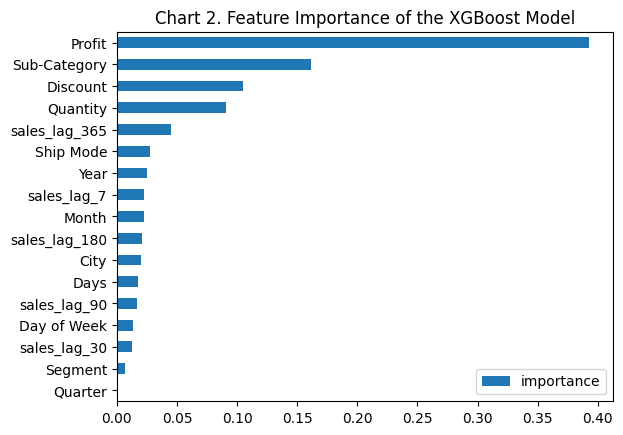

In [220]:
fi = pd.DataFrame(data=boosted_tree_model.feature_importances_,
             index=boosted_tree_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Chart 2. Feature Importance of the XGBoost Model')
plt.show()

### 4.2 Multi-variable linear regression {-}

In [221]:
# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

## 5. Evaluate the model {-}

In [222]:
# Make predictions with XGBoost
y_pred_xgb = boosted_tree_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f"XGBoost RMSE: {rmse_xgb}")

# Make predictions with Linear Regression
y_pred_linear = linear_model.predict(X_test)
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
print(f"Linear Regression RMSE: {rmse_linear}")

XGBoost RMSE: 109.84104717839875
Linear Regression RMSE: 264.34164180957214


/Users/jxiao/Desktop/code/msa/phase2/msa2_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jxiao/Desktop/code/msa/phase2/msa2_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [223]:
# Calculate R^2 for XGBoost
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost R^2: {r2_xgb}")

# Calculate R^2 for Linear Regression
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Linear Regression R^2: {r2_linear}")



XGBoost R^2: 0.904819879650135
Linear Regression R^2: 0.44875065500589895


The result of boosted tree is better than the linear regression model. Let's explore some other metics and visualise the results

/var/folders/w8/w02d673x2yl186vbpbmfssbh0000gn/T/ipykernel_11484/2977699579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = boosted_tree_model.predict(X_test)


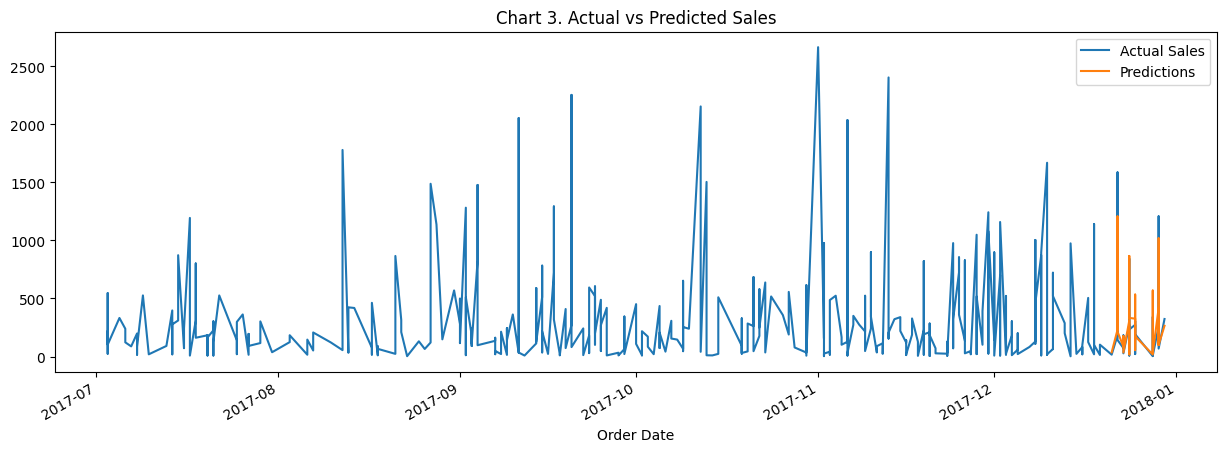

In [224]:
test['prediction'] = boosted_tree_model.predict(X_test)
df_merged = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df_merged = df_merged.loc[(df_merged.index >= '07-01-2017')]
ax = df_merged[['Sales']].plot(figsize=(15, 5))
df_merged['prediction'].plot(ax=ax)
plt.legend(['Actual Sales', 'Predictions'])
ax.set_title('Chart 3. Actual vs Predicted Sales')
plt.show()

In [225]:
# calcuate the SMAPE
smape_value_xgb = smape(y_test, y_pred_xgb)
print(f"sMAPE of xgb model: {smape_value_xgb:.2f}%")
smape_value_lr = smape(y_test, y_pred_linear)
print(f"sMAPE of lr model: {smape_value_lr:.2f}%")


sMAPE of xgb model: 44.70%
sMAPE of lr model: 91.86%


## 6. Summary {-}
### Model Training and Evaluation {-}
- **Features used:**
   - 'Ship Mode',
   - 'Segment',
   - 'City',
   - 'Sub-Category',
   - 'Quantity',
   - 'Discount',
   - 'Profit', this is the most dominant feature. Although it may seem unusual, we assume it is available for predicting sales.
   - 'Day of Week',
   - 'Year',
   - 'Month',
   - 'Quarter',
   - 'Days'
   
   Shifted sales data were also added to capture the time series pattern, the model is designed to predict the sales data fro the next day
   - 'sales_lag_7'
   - 'sales_lag_30'
   - 'sales_lag_90'
   - 'sales_lag_180',
   - 'sales_lag_365'
   
- **Training/Test Splits:**
   - Used data before 2017.12.15 as the training set and data from 2017.12.15 onwards as the test set to ensure consistency and prevent data leaking. 

- **Algorithms Used:**
   - Boosted Tree using XGBoost.
   - Multi-variable Linear Regression.

- **Hyperparameter Tuning:**
   - Employed Cross-Validation Grid Search to optimize the parameters for both models.

- **Performance Metrics:**
   - Boosted Tree: 
     - sMAPE: 44.70%
     - R^2: 90.48%
   - Linear Regression: 
     - sMAPE: 91.86%
     - R^2: 44.88%

   The R-squared value for the boosted tree model indicates that it explains about 90.48% of the variance in the sales data, compared to only 44.88% for the linear regression model. The RMSE and sMAPE values for the boosted tree model are also lower, indicating better predictive accuracy and lower percentage error compared to the linear regression model.

### Conclusion {-}
The boosted tree model outperforms the linear regression model, indicating its ability to capture non-linear patterns in the data. Despite this, there is room for improvement in overall performance. Potential enhancements include explicitly modeling trends and seasonal patterns separately and refining the prediction task to be more specific, such as focusing on certain categories or cities.


